In [2]:
##############################
## 模型验证，先参考数据库中的统计结果，自行设置参数，然后再进行模型验证
##############################
## cvxpy 安装与使用，参考官网https://www.cvxpy.org/
import cvxpy as cp
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt

## 数据生成部分

In [5]:
##############################
## 数据生成
##############################
## 骑手分类
I = 10000
## 每类骑手人数
amount = np.zeros(I)
for i in range(I):
    amount[i] = np.random.randint(50, 150)
## 门槛数额
threshold = {}
for i in range(I):
    threshold[i] = [np.random.randint(8, 11), np.random.randint(15,18), np.random.randint(19, 22), np.random.randint(25, 28)]
## 门槛1奖励金额候选集
reward_1_candidate = [_ for _ in range(10, 20)] ##! 可配置
## 门槛1奖励金额候选集大小
R = len(reward_1_candidate)
## 奖励金距离（门槛2/3/4与门槛1金额的差值）
reward_delta = [16,35,50] ##! 可配置
## 预算
B = 18000000 ##! 可配置
## 做单量概率密度函数 ##! 假设服从泊松分布
gamma = 0.6 ##! 记忆系数
mean_proba = np.zeros((I, R))
for i in range(I):
    for r in range(R):
        mean_proba[i][r] = threshold[i][0] + (7/(threshold[i][1] - threshold[i][0])+gamma*(11/(threshold[i][2]-threshold[i][0]))+(gamma**2)*(17/(threshold[i][3]-threshold[i][0])))\
            *math.log(reward_1_candidate[r])
## 函数：计算开销期望值
def cost_calculation(i,r,mean):
    t1 = threshold[i][0]
    t2 = threshold[i][1]
    t3 = threshold[i][2]
    t4 = threshold[i][3]
    cost = (stats.poisson.cdf(t2-1,mean) - stats.poisson.cdf(t1-1, mean))*r + (stats.poisson.cdf(t3-1,mean) - stats.poisson.cdf(t2-1, mean))*(r+reward_delta[0]) + \
            (stats.poisson.cdf(t4-1,mean) - stats.poisson.cdf(t3-1, mean))*(r+reward_delta[1]) + (1 - stats.poisson.cdf(t4-1,mean))*(r+reward_delta[2])
    return cost
## 做单量参数（v_{ij} in objective function）
value = np.zeros((I, R))
for i in range(I):
    for r in range(R):
        value[i][r] = round((mean_proba[i][r]-threshold[i][0])*amount[i],0)
## 花费参数（c_{ij} in objective function）
cost = np.zeros((I, R))
for i in range(I):
    for r in range(R):
        cost[i][r] = round(cost_calculation(i, reward_1_candidate[r], mean_proba[i][r])*amount[i],0)
        
## 输出 骑手总人数
print(sum(amount))

993443.0


## 参数可视化

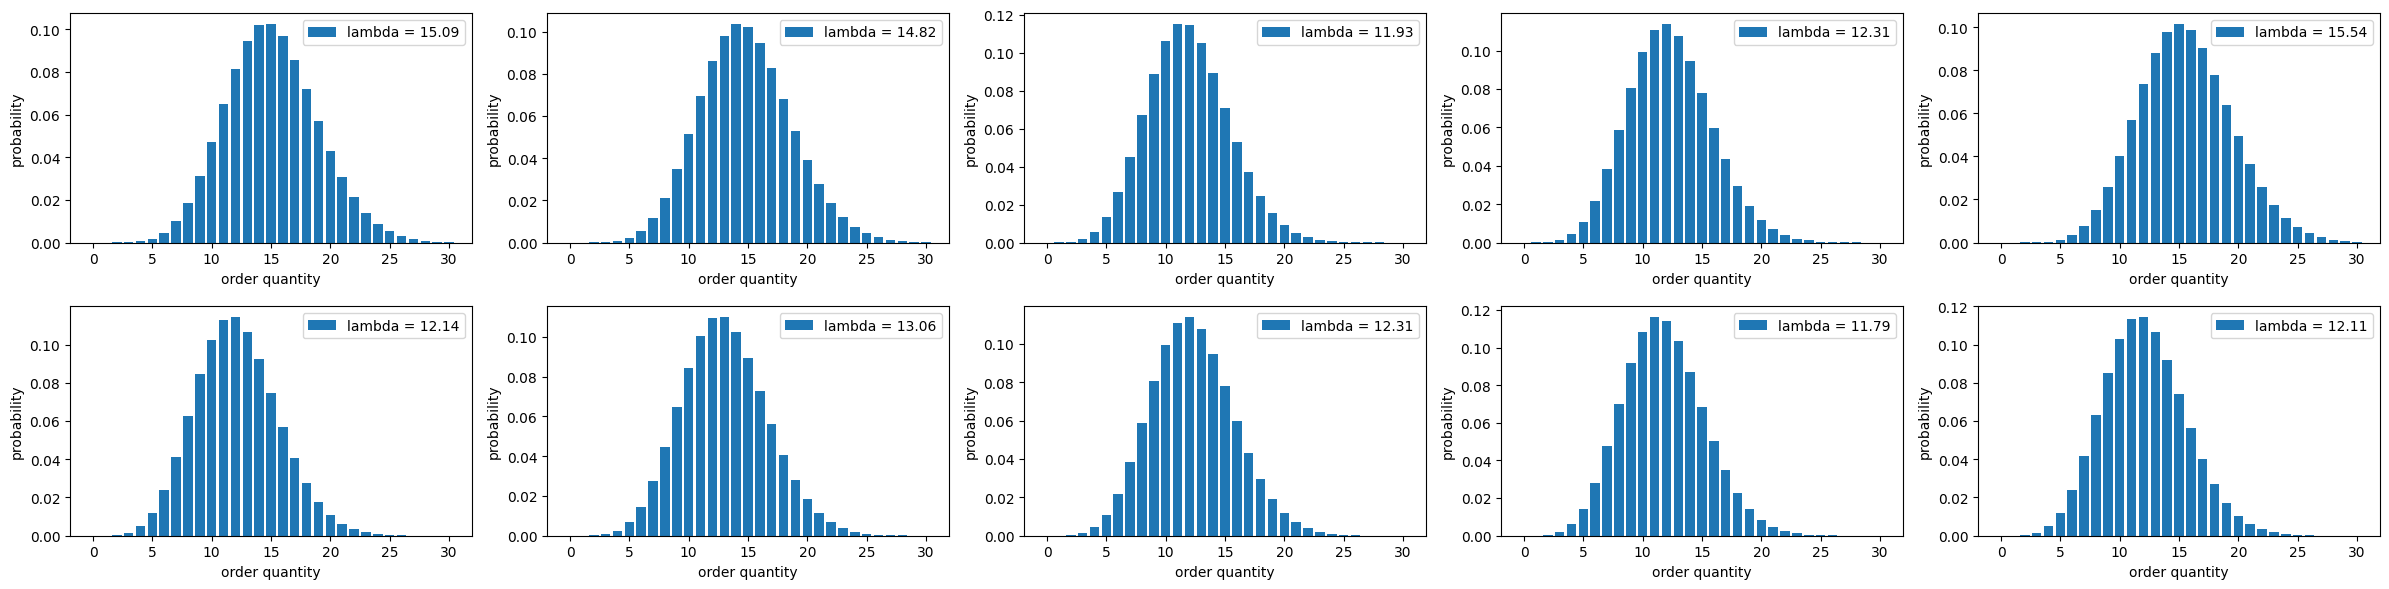

In [142]:
#########################################
## 绘制对应lambda下的泊松分布（骑手做单量分布）
#########################################

k = 30 # 做单量的最大值

# 创建一个 2x5 的子图布局，共有 10 个子图
fig, axs = plt.subplots(2, 5, figsize=(24, 6))

# 将 axs 转换为一维数组
axs = axs.flatten()

# 定义 i 的取值范围
mean_poisson = [mean_proba[i, 0] for i in range(R)] ## 第一类骑手的平均做单量
# 循环迭代 i
for i, ax in zip(mean_poisson, axs):
    x = np.arange(0, k+1, 1)
    plist = stats.poisson.pmf(x, i)
    ax.bar(x, plist, align='center', label='lambda = {}'.format(round(i,2)))
    
    ax.set_ylabel('probability')
    ax.set_xlabel('order quantity')
    
    # lines = ax.get_lines() + ax2.get_lines()
    # labels = [line.get_label() for line in lines]
    ax.legend()
    
plt.tight_layout()
plt.show()

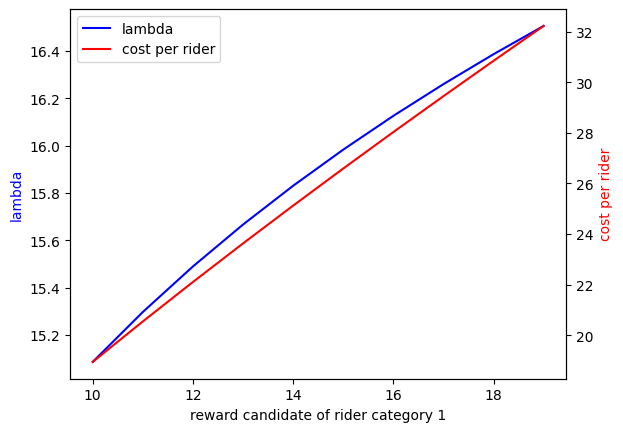

In [131]:
#########################################
## 绘制cost/lambda 与 reward 1 的关系， 以第一类骑手为例
#########################################
i = 0
x = reward_1_candidate
y = [mean_proba[i,r] for r in range(R)] # lambda
z = [cost_calculation(i,reward_1_candidate[r], y[r]) for r in range(R)] # cost
# plt.plot(x,z, '-o',label='cost')
# plt.plot(x,y, '-o',label='lambda')
# plt.legend()
# plt.show()

fig, ax1 = plt.subplots()

ax1.plot(x, y, label='lambda', color='blue')
ax1.set_ylabel('lambda', color='blue')

ax2 = ax1.twinx()
ax2.plot(x, z, label='cost per rider', color='red')
ax2.set_ylabel('cost per rider', color='red')

ax1.set_xlabel('reward candidate of rider category {}'.format(i+1))

lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines,labels)
plt.show()


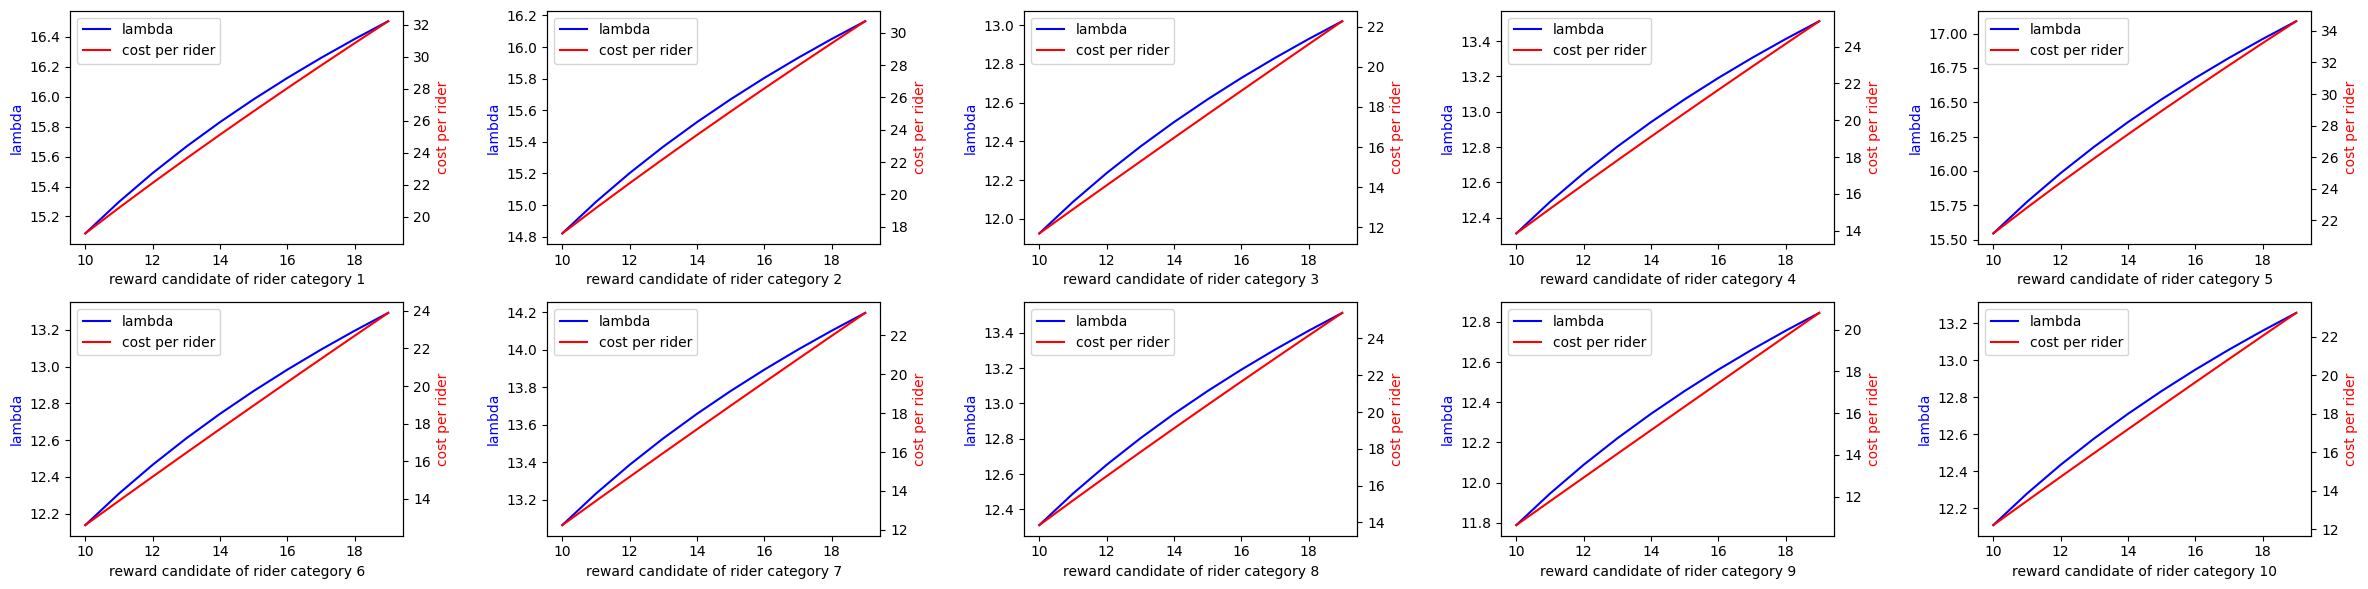

In [132]:
###################################
## 绘制cost/lambda 与 reward 1 的关系，10类骑手
###################################

# 创建一个 2x5 的子图布局，共有 10 个子图
fig, axs = plt.subplots(2, 5, figsize=(24, 6))

# 将 axs 转换为一维数组
axs = axs.flatten()

# 定义 i 的取值范围
i_values = range(10)

# 循环迭代 i
for i, ax in zip(i_values, axs):
    x = reward_1_candidate
    y = [mean_proba[i, r] for r in range(R)] 
    z = [cost_calculation(i, reward_1_candidate[r], y[r]) for r in range(R)]
    
    ax.plot(x, y, label='lambda', color='blue')
    ax.set_ylabel('lambda', color='blue')
    
    ax2 = ax.twinx()
    ax2.plot(x, z, label='cost per rider', color='red')
    ax2.set_ylabel('cost per rider', color='red')
    
    ax.set_xlabel('reward candidate of rider category {}'.format(i+1))
    
    lines = ax.get_lines() + ax2.get_lines()
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels)
    
plt.tight_layout()
plt.show()


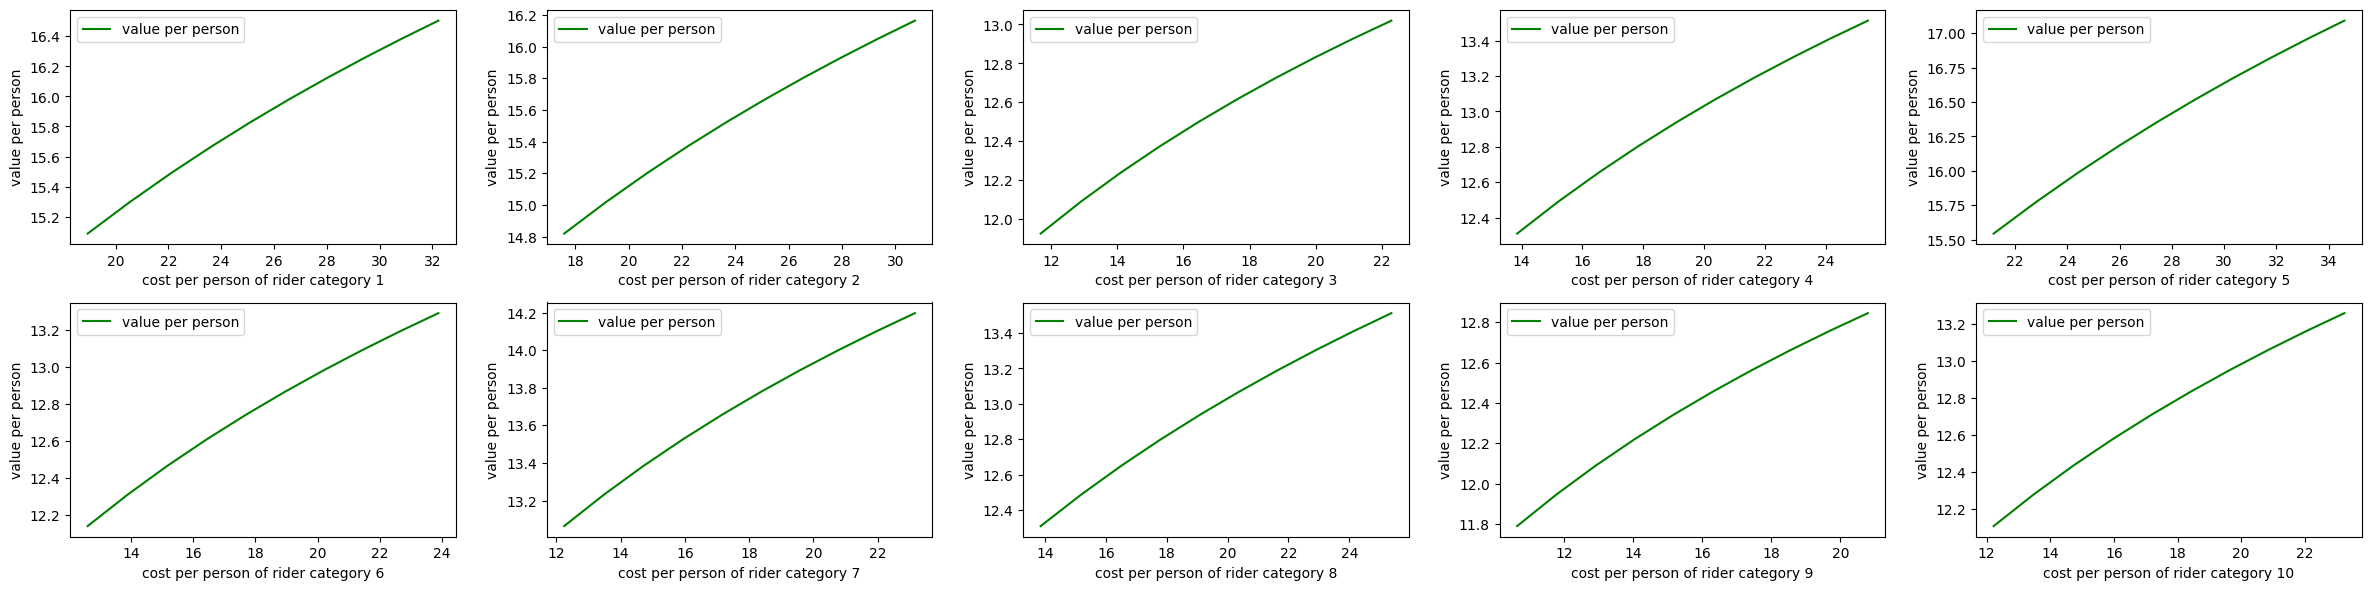

In [136]:
###################################
## 绘制value 与 cost 的关系，10类骑手
## 理想的v_ij / c_ij 应该是递减的
###################################

# 创建一个 2x5 的子图布局，共有 10 个子图
fig, axs = plt.subplots(2, 5, figsize=(24, 6))

# 将 axs 转换为一维数组
axs = axs.flatten()

# 定义 i 的取值范围
i_values = range(10)

# 循环迭代 i
for i, ax in zip(i_values, axs):
    x = reward_1_candidate
    y = [mean_proba[i, r] for r in range(R)] ## value 
    z = [cost_calculation(i, reward_1_candidate[r], y[r]) for r in range(R)] ## cost
    
    ax.plot(z, y, label='value per person', color='green')
    ax.set_ylabel('value per person')
    
    # ax2 = ax.twinx()
    # ax2.plot(x, z, label='cost per rider', color='red')
    # ax2.set_ylabel('cost per rider', color='red')
    
    ax.set_xlabel('cost per person of rider category {}'.format(i+1))
    
    # lines = ax.get_lines() + ax2.get_lines()
    # labels = [line.get_label() for line in lines]
    ax.legend()
    
plt.tight_layout()
plt.show()

## 模型求解部分

In [6]:
##########################################
## 问题求解 (矩阵形式；用cvxpy内置函数求解)
##########################################

## 定义参数
# B = cp.Parameter(nonneg=True)

## 定义变量
X = cp.Variable(cost.shape, boolean=True)
ones_1 = np.ones((cost.shape[1],1))
ones_2 = np.ones((cost.shape[0],1))

## 目标函数
obj = cp.Maximize(cp.sum(cp.multiply(value, X)))

## 约束条件
constraints = []
constraints += [X@ones_1 == ones_2]
constraints += [cp.sum(cp.multiply(cost, X)) <= B]

## 问题求解
problem = cp.Problem(obj, constraints)
problem.solve(verbose=True,solver=cp.SCIPY)


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 17 04:33:36 PM: Your problem has 100000 variables, 2 constraints, and 0 parameters.


(CVXPY) Aug 17 04:33:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 17 04:33:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 17 04:33:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 17 04:33:36 PM: Compiling problem (target solver=SCIPY).
(CVXPY) Aug 17 04:33:36 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCIPY
(CVXPY) Aug 17 04:33:36 PM: Applying reduction FlipObjective
(CVXPY) Aug 17 04:33:36 PM: Applying reduction Dcp2Cone
(CVXPY) Aug 17 04:33:36 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 17 04:33:36 PM: Applying reduction C

4892152.0

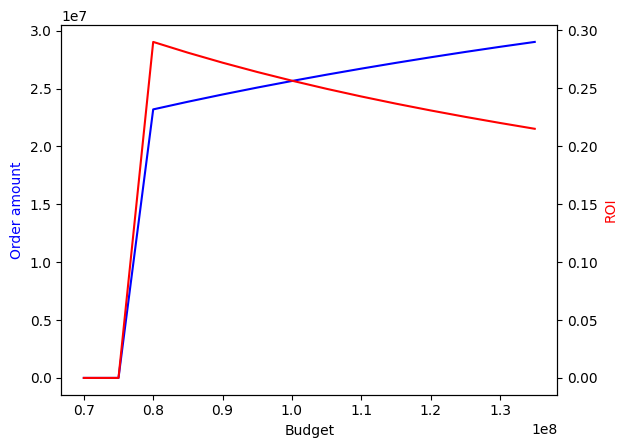

In [4]:
###############################################
## 参数控制求解
###############################################
B_values = np.arange(70000000, 140000000, 5000000)
Obj_values = []
for val in B_values:
    B.value = val
    problem.solve(solver=cp.SCIPY)
    if problem.status == 'infeasible':
        Obj_values.append(0)
    else:
        Obj_values.append(problem.value)

## 画图
fig, ax1 = plt.subplots()

ax1.plot(list(B_values), Obj_values, 'b-', label='Order')
ax1.set_xlabel('Budget')
ax1.set_ylabel('Order amount', color='b')
# ax1.tick_params(axis='Objective Value')

roi = [Obj_values[i]/B_values[i] for i in range(len(Obj_values))]
ax2 = ax1.twinx()
ax2.plot(list(B_values), roi ,'r-', label='ROI')
ax2.set_ylabel('ROI', color='r')
# ax2.tick_params(axis='ROI')

# plt.legend()
plt.show()

In [92]:
problem.value

47642.0

In [43]:
##################################################
## 输出方案
##################################################
for i in range(I):
    for r in range(R):
        if X[(i,r)].value == 1:
            print('第{}类骑手的智能活动策略为:门槛1为{}, 金额1为{}; 门槛2为{}, 金额2为{}; \
                门槛3为{}, 金额3为{}; 门槛4为{}, 金额4为{}'.format(i+1,threshold[i][0],reward_1_candidate[r],\
                    threshold[i][1],reward_1_candidate[r]+reward_delta[0], threshold[i][2],reward_1_candidate[r]+reward_delta[1],\
                        threshold[i][3],reward_1_candidate[r]+reward_delta[2]))

第1类骑手的智能活动策略为:门槛1为9, 金额1为15; 门槛2为16, 金额2为31;                 门槛3为19, 金额3为50; 门槛4为25, 金额4为65
第2类骑手的智能活动策略为:门槛1为9, 金额1为15; 门槛2为17, 金额2为31;                 门槛3为21, 金额3为50; 门槛4为26, 金额4为65
第3类骑手的智能活动策略为:门槛1为10, 金额1为15; 门槛2为16, 金额2为31;                 门槛3为20, 金额3为50; 门槛4为27, 金额4为65
第4类骑手的智能活动策略为:门槛1为8, 金额1为16; 门槛2为15, 金额2为32;                 门槛3为21, 金额3为51; 门槛4为25, 金额4为66
第5类骑手的智能活动策略为:门槛1为10, 金额1为18; 门槛2为15, 金额2为34;                 门槛3为19, 金额3为53; 门槛4为26, 金额4为68
第6类骑手的智能活动策略为:门槛1为10, 金额1为16; 门槛2为17, 金额2为32;                 门槛3为19, 金额3为51; 门槛4为26, 金额4为66
第7类骑手的智能活动策略为:门槛1为8, 金额1为14; 门槛2为15, 金额2为30;                 门槛3为20, 金额3为49; 门槛4为26, 金额4为64
第8类骑手的智能活动策略为:门槛1为8, 金额1为17; 门槛2为15, 金额2为33;                 门槛3为19, 金额3为52; 门槛4为26, 金额4为67
第9类骑手的智能活动策略为:门槛1为10, 金额1为16; 门槛2为16, 金额2为32;                 门槛3为19, 金额3为51; 门槛4为25, 金额4为66
第10类骑手的智能活动策略为:门槛1为8, 金额1为15; 门槛2为17, 金额2为31;                 门槛3为21, 金额3为50; 门槛4为26, 金额4为65
第11类骑手的智能活动策略为:门槛1为9, 金额1为16; 门槛2为17, 金额2为32;                 门槛3为21, 金额3为5

In [44]:
########################################
## 问题求解 （一条条约束添加）
########################################

## 定义变量
X = {}
for i in range(I):
    for r in range(R):
        X[(i,r)] = cp.Variable(boolean=True)
## 定义目标函数
obj = cp.Maximize(cp.sum([value[i,r]*X[(i,r)] for i in range(I) for r in range(R)]))
## 定义约束条件
constraints = []
constraints += [cp.sum([cost[i,r]*X[(i,r)] for i in range(I) for r in range(R)]) <= B]
for i in range(I):
    constraints += [cp.sum([X[(i,r)] for r in range(R)]) == 1]
## 求解问题
problem = cp.Problem(obj, constraints)
problem.solve(verbose=True,solver=cp.SCIPY)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 08 03:00:49 PM: Your problem has 1000 variables, 101 constraints, and 0 parameters.
(CVXPY) Aug 08 03:00:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 08 03:00:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 08 03:00:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 08 03:00:49 PM: Compiling problem (target solver=SCIPY).
(CVXPY) Aug 08 03:00:49 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr ->

132040.0

In [45]:
for i in range(I):
    for r in range(R):
        if X[(i,r)].value == 1:
            print('第{}类骑手的智能活动策略为:门槛1为{}, 金额1为{}; 门槛2为{}, 金额2为{}; \
                门槛3为{}, 金额3为{}; 门槛4为{}, 金额4为{}'.format(i+1,threshold[i][0],reward_1_candidate[r],\
                    threshold[i][1],reward_1_candidate[r]+reward_delta[0], threshold[i][2],reward_1_candidate[r]+reward_delta[1],\
                        threshold[i][3],reward_1_candidate[r]+reward_delta[2]))

第1类骑手的智能活动策略为:门槛1为9, 金额1为15; 门槛2为16, 金额2为31;                 门槛3为19, 金额3为50; 门槛4为25, 金额4为65
第2类骑手的智能活动策略为:门槛1为9, 金额1为15; 门槛2为17, 金额2为31;                 门槛3为21, 金额3为50; 门槛4为26, 金额4为65
第3类骑手的智能活动策略为:门槛1为10, 金额1为15; 门槛2为16, 金额2为31;                 门槛3为20, 金额3为50; 门槛4为27, 金额4为65
第4类骑手的智能活动策略为:门槛1为8, 金额1为16; 门槛2为15, 金额2为32;                 门槛3为21, 金额3为51; 门槛4为25, 金额4为66
第5类骑手的智能活动策略为:门槛1为10, 金额1为18; 门槛2为15, 金额2为34;                 门槛3为19, 金额3为53; 门槛4为26, 金额4为68
第6类骑手的智能活动策略为:门槛1为10, 金额1为16; 门槛2为17, 金额2为32;                 门槛3为19, 金额3为51; 门槛4为26, 金额4为66
第7类骑手的智能活动策略为:门槛1为8, 金额1为14; 门槛2为15, 金额2为30;                 门槛3为20, 金额3为49; 门槛4为26, 金额4为64
第8类骑手的智能活动策略为:门槛1为8, 金额1为17; 门槛2为15, 金额2为33;                 门槛3为19, 金额3为52; 门槛4为26, 金额4为67
第9类骑手的智能活动策略为:门槛1为10, 金额1为16; 门槛2为16, 金额2为32;                 门槛3为19, 金额3为51; 门槛4为25, 金额4为66
第10类骑手的智能活动策略为:门槛1为8, 金额1为15; 门槛2为17, 金额2为31;                 门槛3为21, 金额3为50; 门槛4为26, 金额4为65
第11类骑手的智能活动策略为:门槛1为9, 金额1为16; 门槛2为17, 金额2为32;                 门槛3为21, 金额3为5